In [31]:
from utils.utils import calculate_attributions

archive_name = 'ucr'
classifier = 'fcn_itr_0'
mode = 'stl' 
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
itr = '_itr_'
appendix = 'original'
dataset_name = 'GunPoint'
att  = calculate_attributions(root_dir, archive_name, classifier,  \
                                                    dataset_name, appendix, mode,  task=1)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_0/original/best_model.hdf5
(50, 150, 1) (150, 150, 1)


In [32]:
import pandas as pd
pd.DataFrame(att[0])

,0,1,2,3,4,5,6
0,0,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-0.64789, -0.6474502301150575, -0.64701046023...","[20, 19, 17, 16, 14, 13, 11, 10, 9, 7, 6, 4, 3...",0,1,"[-0.64789, -0.64199, -0.63819, -0.63826, -0.63..."
1,1,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-0.64443, -0.6445023011505753, -0.64457460230...","[19, 18, 17, 15, 14, 12, 11, 10, 8, 7, 5, 4, 3...",0,1,"[-0.64443, -0.6454, -0.64706, -0.64749, -0.646..."
2,2,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-0.77835, -0.7783447823911955, -0.77833956478...","[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 4...",0,0,"[-0.77835, -0.77828, -0.77715, -0.77768, -0.77..."
3,3,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-0.75006, -0.7499139069534767, -0.74976781390...","[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...",0,0,"[-0.75006, -0.7481, -0.74616, -0.74593, -0.743..."
4,4,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-0.59954, -0.5993819809904952, -0.59922396198...","[19, 18, 16, 15, 13, 12, 10, 9, 7, 6, 4, 3, 2,...",0,1,"[-0.59954, -0.59742, -0.59927, -0.59826, -0.59..."
5,5,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-0.54774, -0.5481812606303151, -0.54862252126...","[21, 19, 18, 16, 14, 13, 11, 10, 8, 6, 5, 3, 2...",0,1,"[-0.54774, -0.55366, -0.55719, -0.5596, -0.564..."
6,6,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-1.2612, -1.2637119059529767, -1.266223811905...","[28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 1...",0,1,"[-1.2612, -1.2949, -1.3101, -1.3196, -1.3203, ..."
7,7,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-2.0126, -2.0125627313656826, -2.012525462731...","[40, 38, 37, 36, 34, 33, 31, 30, 28, 27, 26, 2...",0,1,"[-2.0126, -2.0121, -2.0116, -2.0135, -2.0134, ..."
8,8,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-1.0656, -1.065667083541771, -1.0657341670835...","[21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 1...",0,1,"[-1.0656, -1.0665, -1.0672, -1.0682, -1.0676, ..."
9,9,"[0.0, 0.07453726863431716, 0.14907453726863432...","[-1.1772, -1.177095647823912, -1.1769912956478...","[51, 52, 53, 55, 56, 58, 59, 61, 62, 64, 65, 6...",0,0,"[-1.1772, -1.1758, -1.1732, -1.1709, -1.1695, ..."


In [118]:
output_directory = 'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_0/original/'
def save_attributions(output_directory, att, task, save_mode = 1): 
    task_name = 'task_1' if task == 1 else 'task_2'
    att_train, att_test = att
    if save_mode == 1: 
        np.save(output_directory  + f'calculated_attribution_train_{task_name}.npy', att_train)
        np.save(output_directory  + f'calculated_attribution_test_{task_name}.npy', att_test)
    if save_mode == 2:
        pd.DataFrame(att_train, columns=['ts_nr','x_val','y_val','attributions','pred_y','true_y','orginal_ts'])\
        .to_csv(output_directory + f'calculated_attribution_train_{task_name}.csv')
        pd.DataFrame(att_train, columns=['ts_nr','x_val','y_val','attributions','pred_y','true_y','orginal_ts'])\
        .to_csv(output_directory + f'calculated_attribution_test_{task_name}.csv')
    print("Saved attributions")

save_attributions(output_directory, att, task=1)

Saved attributions


In [111]:
type(np.load(output_directory + f'calculated_attribution_train_task_1.npy', allow_pickle = True)[0][3])

numpy.ndarray

In [26]:
df = pd.read_csv(output_directory + "calculated_attribution_train.csv")
df.iloc[0]

Unnamed: 0                                                      0
ts_nr                                                           0
x_val           [0.00000000e+00 7.45372686e-02 1.49074537e-01 ...
y_val           [-0.64789    -0.64745023 -0.64701046 ... -0.63...
attributions                              [20 19 17 ... 10 10 10]
pred_y                                                          0
true_y                                                          1
orginal_ts      [-0.64789  -0.64199  -0.63819  -0.63826  -0.63...
Name: 0, dtype: object

In [44]:
output_directory = 'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_itr_0/unbalanced_exp/'

In [40]:
archive_name = 'ucr'
classifier = 'fcn_mt_itr_0'
mode = 'mtl' 
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
itr = '_itr_'
appendix = 'unbalanced_exp'
dataset_name = 'GunPoint'
att_1  = calculate_attributions(root_dir, archive_name, classifier,  \
                                                    dataset_name, appendix, mode,  task=1)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_itr_0/unbalanced_exp/best_model.hdf5
yes
(50, 150, 1) (150, 150, 1)


In [46]:
att_2  = calculate_attributions(root_dir, archive_name, classifier,  \
                                                    dataset_name, appendix, mode,  task=2)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_itr_0/unbalanced_exp/best_model.hdf5
(50, 150, 1) (150, 150, 1)


In [47]:
save_attributions(output_directory, att_1, task=1)
save_attributions(output_directory, att_2, task=2)

Saved attributions
Saved attributions


In [101]:
import numpy as np
y_true = []
y_pred = []

for i in att_2[1]:
    y_pred.append(i[4])
    y_true.append(i[5])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(y_true.shape,set(y_true),set(y_pred))


(150,) {0, 1, 2} {1, 2}


   0    1  2
0  0    9  0
1  0  129  4
2  0    7  1


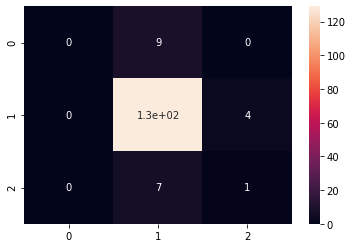

In [102]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import seaborn as sns

cfm = confusion_matrix(y_true,y_pred)

cfm = pd.DataFrame(cfm)

# y_test  : actual labels or target
# y_preds : predicted labels or target
sns.heatmap(cfm,annot=True);
print(cfm)

In [94]:
creport = classification_report(y_true,y_pred,labels=list(set(y_true)),output_dict=True)

C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
pd.DataFrame(creport)

,0,1,2,accuracy,macro avg,weighted avg
precision,0.0,0.875000,1.000000,0.88,0.625000,0.835000
recall,0.0,1.000000,0.400000,0.88,0.466667,0.880000
f1-score,0.0,0.933333,0.571429,0.88,0.501587,0.841143
support,3.0,42.000000,5.000000,0.88,50.000000,50.000000


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

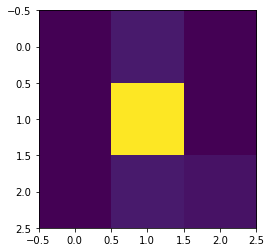

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

display_labels = set(y_true)

disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                              display_labels=display_labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
#confusion_matrix=np.asarray([[13099,7004],[27420,544967]]), display_labels= np.asarray([0,1])) 
disp = disp.plot(include_values=cfm)
                 #cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)



plt.show()